# 7.1 AlexNet

第一部分主要讲解了AlexNet出现的背景，由于数据增多和硬件（GPU）的发展，能够探索跟深的卷积神经网络

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))


In [2]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

KeyboardInterrupt: 

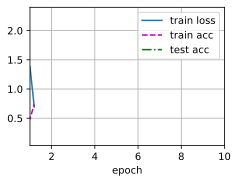

In [3]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

- AlexNet的架构与LeNet相似，但使用了更多的卷积层和更多的参数来拟合大规模的ImageNet数据集。
- 今天，AlexNet已经被更有效的架构所超越，但它是从浅层网络到深层网络的关键一步。
- 尽管AlexNet的代码只比LeNet多出几行，但学术界花了很多年才接受深度学习这一概念，并应用其出色的实验结果。这也是由于缺乏有效的计算工具。
- Dropout、ReLU和预处理是提升计算机视觉任务性能的其他关键步骤。

# 7.2 VGG

- VGG就是AlexNet的加强版，相当于把多个卷积层封装成块
- 不同块和深度构成VGG具有不同的版本

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layer = []
    for _ in range(num_convs):
        layer.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layer.append(nn.ReLU())
        in_channels = out_channels
    layer.append(nn.MaxPool2d(kernel_size=2))
    return nn.Sequential(*layer)

In [5]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels= 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)


In [8]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.3 NiN

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [10]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

In [11]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


- NiN使用由一个卷积层和多个1 x 1卷积层组成的块。该块可以在卷积神经网络中使用，以允许更多的每像素非线性。
- NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进行求和）。该汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。
- 移除全连接层可减少过拟合，同时显著减少NiN的参数。
- NiN的设计影响了许多后续卷积神经网络的设计。

# 7.4 GoogLeNet

In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)

        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)

        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)

        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, X):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
        p4 = F.relu(self.p4_2(self.p4_1(X)))
        return torch.cat([p1, p2, p3, p4], dim=1)


In [16]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


- Inception块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大汇聚层来并行抽取信息，并使用1 x 1卷积层减少每像素级别上的通道维数从而降低模型复杂度。
- GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在ImageNet数据集上通过大量的实验得来的。
- GoogLeNet和它的后继者们一度是ImageNet上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。

# 7.5 批次归一化

批次归一化就是让输入和输出前后这一批次某一维度或者某一通道的分布尽可能不变。对数值有一个计算公式。

In [28]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape)  == 2:
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=0, keepdim=True)

    X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [29]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super(BatchNorm, self).__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.ones(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [ ]:
X = torch.rand(size=(1, 10, 96, 96))
batchnorm = BatchNorm(10, 4)
batchnorm_x = batchnorm(X)

tensor([[[[1.0903e-03, 2.4080e-04, 1.9978e+00,  ..., 2.3365e-05,
           2.5272e-05, 4.1783e-05],
          [2.9241e-03, 1.9927e+00, 2.0000e+00,  ..., 2.0000e+00,
           2.8729e-05, 2.0000e+00],
          [3.6955e-05, 1.9999e+00, 2.5511e-05,  ..., 2.0000e+00,
           2.0000e+00, 8.4341e-05],
          ...,
          [2.0000e+00, 1.9999e+00, 3.0756e-05,  ..., 2.0000e+00,
           4.3392e-05, 2.7001e-05],
          [2.5392e-05, 1.9992e+00, 4.6730e-05,  ..., 6.3479e-05,
           2.2119e-03, 2.0000e+00],
          [1.9980e+00, 5.7340e-05, 1.9989e+00,  ..., 2.0000e+00,
           1.4389e-04, 2.0000e+00]],

         [[6.1214e-05, 1.9999e+00, 7.8380e-05,  ..., 4.0686e-04,
           2.0000e+00, 1.3447e-04],
          [4.3869e-05, 2.7955e-05, 2.0000e+00,  ..., 1.1551e-04,
           2.4974e-05, 3.1680e-04],
          [8.5175e-05, 2.7895e-05, 7.8142e-05,  ..., 1.1815e+00,
           2.0000e+00, 2.0000e+00],
          ...,
          [2.0000e+00, 1.9999e+00, 3.0577e-05,  ..., 1.0824

# 7.5 ResNet

In [37]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, in_channels, num_channels, is_use_conv1=False, strides=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)

        if is_use_conv1:
            self.conv3 = nn.Conv2d(in_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.conv3:
            x = self.conv3(x)
        y += x
        return F.relu(y)

blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [39]:
blk = Residual(3,6,is_use_conv1=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [41]:
def resnet_block(in_channels, num_channels, num_blocks, first_block=False):
    blk = []
    for i in range(num_blocks):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, num_channels, is_use_conv1=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    
    return blk

        

In [42]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [43]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [44]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])
